In [62]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import shap
import xgboost
import optuna
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pickle
shap.initjs()
import torch
import numpy as np

In [2]:
500/ (500+268)

0.6510416666666666

In [3]:
data = pd.read_csv("diabetes.csv")

X = data.drop(columns = ["Outcome"])
y = data["Outcome"]

In [4]:
data['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [5]:
X = data.drop(columns = ["Outcome"])
y = data["Outcome"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)


In [7]:
#X_train, y_train = SMOTE().fit_resample(X_train, y_train)

In [8]:
scaler=StandardScaler()
X_train_std=pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_std=pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)


In [9]:
def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])

In [10]:
def objective(trial):

    
    param = {
        "learning_rate": trial.suggest_float("learning_rate",0,1),
        "n_estimators": trial.suggest_categorical("n_estimators", [50,100,1000,2000,5000]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log = True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log = True),
        "max_depth": trial.suggest_int("max_depth",3,6),
        "subsample": trial.suggest_float("subsample",0,1),
        "colsample_bytree": trial.suggest_float("subsample",0,1),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "gamma": trial.suggest_float("gamma", 0,4)
        

        
    }


    classifier =  XGBClassifier(**param, objective = "binary:logistic", device= 'cpu')
    classifier.fit(X_train_std,y_train)

    preds = classifier.predict(X_test_std)
    trial.set_user_attr(key="best_booster", value=classifier)

    return accuracy_score(y_test, preds)

In [11]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1500, show_progress_bar = True)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [12]:
classifier = study.best_trial.user_attrs["best_booster"]

In [13]:
preds = classifier.predict(X_test_std)

In [14]:
accuracy_score(y_test, preds)

0.8701298701298701

In [15]:
classifier.save_model(f'acc{str(round(accuracy_score(y_test, preds),4))[2:]}.json')

In [105]:
classifier.load_model("acc8831.json")

In [106]:
explainer = shap.TreeExplainer(classifier)
shap_values = explainer(X_test)

[00:23:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


# Global Visualisations

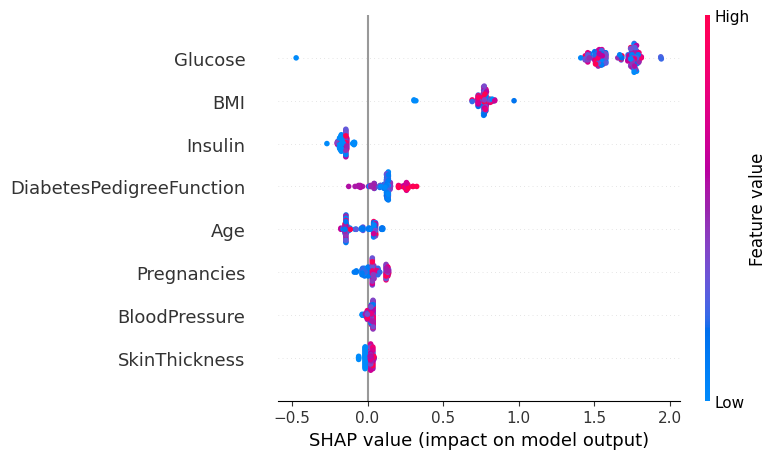

In [104]:
shap.summary_plot(shap_values, X_test)

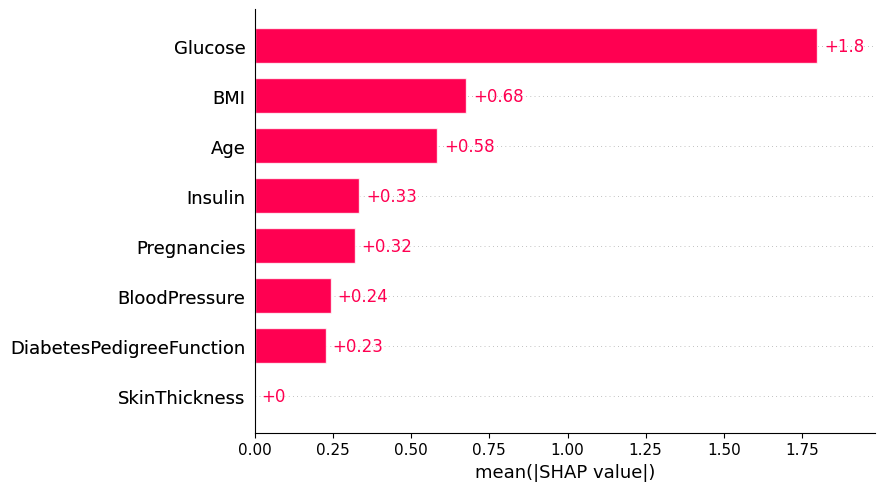

In [76]:
shap.plots.bar(shap_values, )

# Local Visualisations

In [40]:
preds

array([1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [88]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [89]:
shap_values.data = data

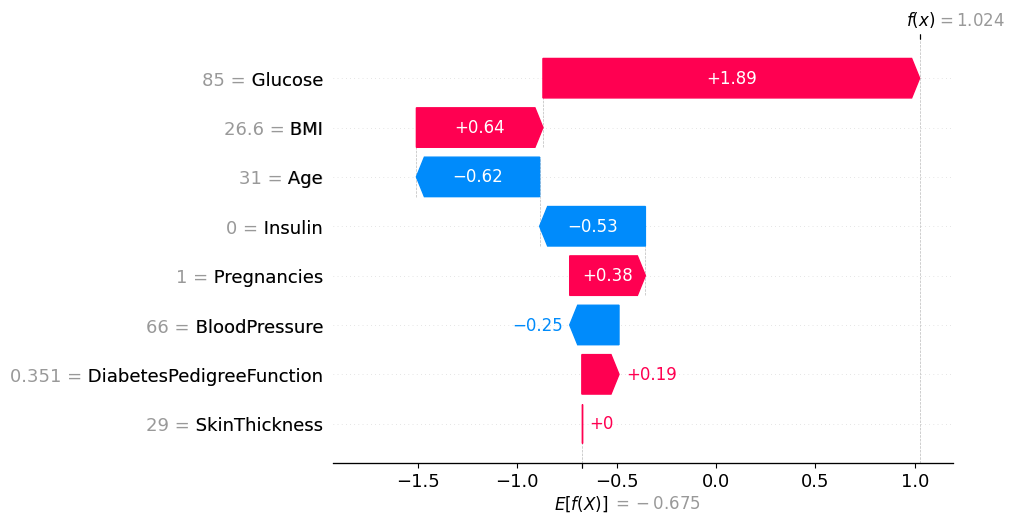

In [101]:
shap.plots.waterfall(shap_values[1])

In [64]:
shap.plots.force(shap_values[5])